In [0]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import models, layers, optimizers
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/Colab Notebooks/tomato/preprocessed_dataset'
!ls

/content/gdrive/My Drive/Colab Notebooks/tomato/preprocessed_dataset
test  tomato_xception.h5  train  validation


In [4]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'train',
    batch_size=25)
validation_generator = validation_datagen.flow_from_directory(
    'validation',
    batch_size=25)

Found 7000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


In [5]:
# create the base pre-trained model
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(256,256,3))

83689472/83683744 [==============================] - 1s 0us/step


In [0]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [0]:
len(conv_base.layers)

132

In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 21,915,698
Trainable params: 21,861,170
Non-trainable params: 54,528
_________________________________________________________________


In [7]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 158


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [0]:
callbacks_list = [
  ModelCheckpoint(
    filepath='tomato_xception_v2.h5',
    monitor='val_loss',
    save_best_only=True, 
  ),
  ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
  )
]

In [13]:
history = model.fit(
      train_generator,
      steps_per_epoch=280,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=60,
      callbacks=callbacks_list)

Epoch 1/100
280/280 [==============================] - 4857s 17s/step - loss: 0.7013 - accuracy: 0.7680 - val_loss: 0.3667 - val_accuracy: 0.8980 - lr: 1.0000e-04
Epoch 2/100
280/280 [==============================] - 225s 802ms/step - loss: 0.1467 - accuracy: 0.9506 - val_loss: 0.1544 - val_accuracy: 0.9420 - lr: 1.0000e-04
Epoch 3/100
280/280 [==============================] - 226s 807ms/step - loss: 0.0931 - accuracy: 0.9693 - val_loss: 0.0788 - val_accuracy: 0.9740 - lr: 1.0000e-04
Epoch 4/100
280/280 [==============================] - 225s 805ms/step - loss: 0.0643 - accuracy: 0.9789 - val_loss: 0.0647 - val_accuracy: 0.9800 - lr: 1.0000e-04
Epoch 5/100
280/280 [==============================] - 223s 797ms/step - loss: 0.0530 - accuracy: 0.9829 - val_loss: 0.1089 - val_accuracy: 0.9740 - lr: 1.0000e-04
Epoch 6/100
280/280 [==============================] - 224s 798ms/step - loss: 0.0434 - accuracy: 0.9840 - val_loss: 0.2236 - val_accuracy: 0.9480 - lr: 1.0000e-04
Epoch 7/100
280/2

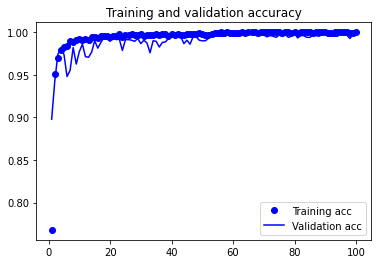

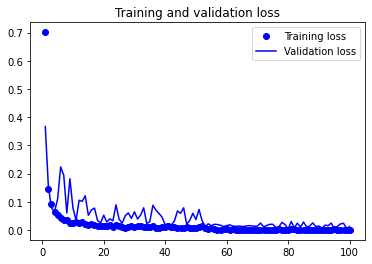

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

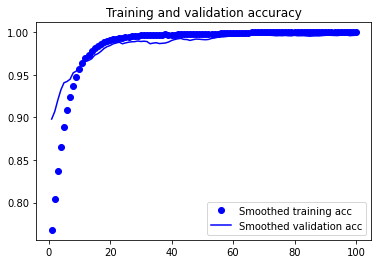

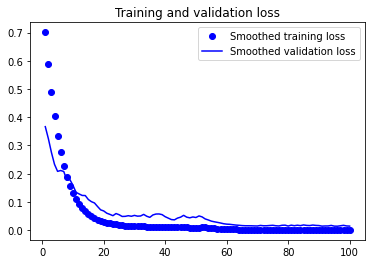

In [15]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
model.save('tomato_xception_final.h5')

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'test',
    batch_size=25)
test_loss, test_acc = model.evaluate(test_generator, steps=60)
print('test acc:', test_acc)

Found 1500 images belonging to 10 classes.
25/60 [===========>..................] - ETA: 8:26 - loss: 0.0290 - accuracy: 0.9968